
# Project Data Analytics
## Model-Agnostic Meta-Learning in the Context of Speech Algorithms

<center><b>
Prof. Dr. Dr. Lars Schmidt-Thieme,<br>
Supervisor: Rafael Rêgo Drumond, M.Sc.<br>
Information Systems and Machine Learning Lab<br>
University of Hildesheim<br>
</b>
    <br>
    <br>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Universit%C3%A4t_Hildesheim_logo.svg/1200px-Universit%C3%A4t_Hildesheim_logo.svg.png" height="10%" width="10%">
</center>

# Speech Recognition

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display

import os
from random import randint

#coefficients
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from scipy.signal.windows import hann
import speech_recognition as speech_recog
import librosa
import librosa.display

#hmm
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix

#cnn
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

**Installing libraries for audio handling:**<br>
- conda install -c conda-forge librosa
- pip install python_speech_features
- pip install librosa
- pip install SpeechRecognition
- pip install --upgrade --user hmmlearn

1. Recover audio file

In [84]:
folderFromData='speech_commands_v0.01/'
commandsToLearn = ["yes","one","left"]

In [4]:
def getListOfFiles(dirName):
    # Retrieved from: https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

#Build dictionary of all the commands in the shape of a list.
# i.e. dog -> ["pathToFile1","pathToFile2"...]
dicDataSet = {}

for command in commandsToLearn:
    dicDataSet[command] = getListOfFiles(folderFromData+command)

In [5]:
def getRandomFile(command,dicDS):
    #Gets a random file path from the specific command, given the dictionary
    i = randint(0,len(dicDS[command])-1) #dont include last index
    return dicDS[command][i]
#getRandomFile("dog",dicDataSet)

In [6]:
#audio_path = librosa.util.example_audio_file()
#audio_path = 'speech_commands_v0.01/dog/ffd2ba2f_nohash_0.wav'
audio_path = getRandomFile("one", dicDataSet)
print("Opening file: "+audio_path)
#Returns : audio time series and sampling rate
timeSeries, samplingRate = librosa.load(audio_path,sr=16000)

Opening file: speech_commands_v0.01/one\9b5815cd_nohash_2.wav


Use librosa library to transform it into a spectogram

In [7]:
spectogram = librosa.feature.melspectrogram(timeSeries,sr=samplingRate, n_mels = 128)
#Transform to a logaritmic
log_spectogram = librosa.power_to_db(spectogram, ref=np.max)

Display the spectrogram on a mel scale<br>
The sample rate and hop length parameters are used to render the time axis

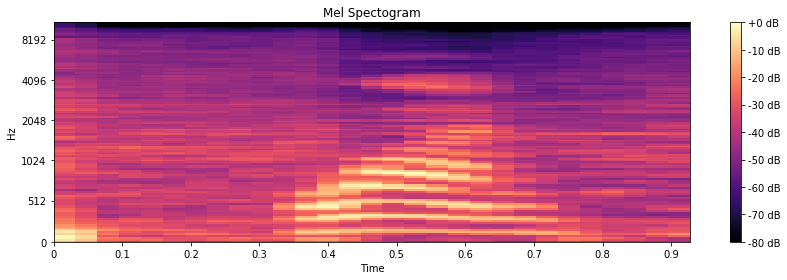

In [8]:
plt.figure(figsize=(12,4))

librosa.display.specshow(log_spectogram, sr=samplingRate, x_axis='time', y_axis='mel')
plt.title('Mel Spectogram')
# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

The outputs are different between two libraries: speech feature extration and librosa. I did some research but couldn't find a good answer for it. It seems people are confused as well. - ECE

### MFCC with librosa

 Getting coefficients (MFCCs) and visualize them by **librosa**


(13, 90)


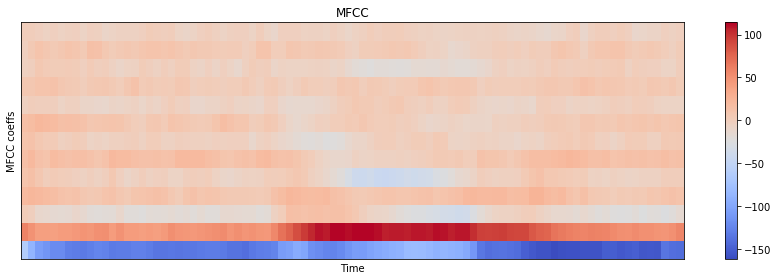

In [70]:
#https://www.kaggle.com/davids1992/speech-representation-and-data-exploration

#We should get a more detailed explanation of what every of these parameters do:
n_mfcc = 13
n_mels = 40
n_fft = 512 
hop_length = 160
fmin = 0
fmax = None

librosa_mfcc = librosa.feature.mfcc(y = timeSeries, sr = samplingRate, n_fft = n_fft, n_mels = n_mels, n_mfcc = n_mfcc, hop_length=hop_length, fmin=fmin, fmax=fmax, htk=False)
delta2_mfcc = librosa.feature.delta(librosa_mfcc, order = 2)

print(np.shape(delta2_mfcc))

plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()


input for NN -> spectrograms 
<br>
input for others -> MFCCs

*In classical, but still state-of-the-art systems, MFCC or similar features are taken as the input to the system instead of spectrograms. However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example MFCC decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible.a*

### MFCC with python_speech_features

 Getting coefficients (MFCCs) and visualize them by **speech_features**


(88, 13)
(13,)


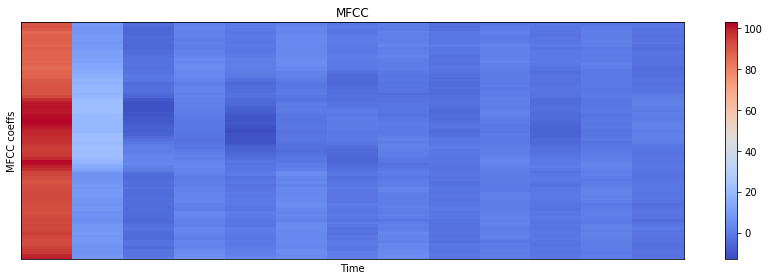

In [71]:
rate, sig  = wav.read(audio_path)    


mfcc_feat = mfcc(signal = sig, samplerate = rate,  winstep=hop_length / rate, winlen=n_fft / rate, numcep=n_mfcc, nfilt=n_mels, nfft=n_fft, lowfreq=fmin, highfreq=fmax,
                                          preemph=0.0, ceplifter=0, appendEnergy=False, winfunc=hann)


print(np.shape(mfcc_feat))
print(mfcc_feat[0].shape)


d_mfcc_feat = delta(mfcc_feat, 2)
fbank_feat = logfbank(sig,rate)


plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc_feat)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

array([-0.08777618, -0.19206282, -0.24306476, ..., -0.03839653,
       -0.06406289,  0.        ], dtype=float32)

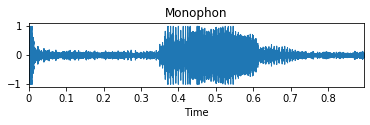

In [11]:

#y, sr = librosa.load(audio_path,sr=16000)
y, sr = librosa.load(audio_path)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Monophon')
y.shape
y

Using wav library, the limits are different, but the signal is the same.
#Apply normalization.

differences here: https://stackoverflow.com/questions/50062358/difference-between-load-of-librosa-and-read-of-scipy-io-wavfile

<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Monophon')

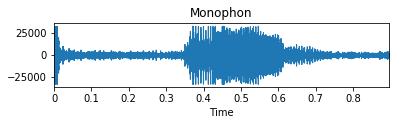

In [12]:
#y, sr = librosa.load(audio_path,sr=16000)
rate, sig  = wav.read(audio_path)
#Normalizing
#sig = (sig - sig.min())/(sig.max()-sig.min())

print(type(sig))

plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(sig.astype(float), sr=rate)
plt.title('Monophon')

## GMMHMM Implementation

### Pre-processing

In [85]:
def getListOfFiles(dirName, command):
    # Retrieved from: https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = []
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append((command, fullPath))        
    return allFiles

dataset = []
dataset_total = []

for command in commandsToLearn:
    dataset.append(getListOfFiles(folderFromData+command, command))

dataset = np.asarray(dataset)
k=10


for i in range (np.shape(dataset)[0]):
    
    dataset_total += dataset[i][:k] # only k number files of every label 
    #dataset_total += dataset[i] #all files of every label
    
np.random.shuffle(dataset_total)

#df = pd.DataFrame(columns = ['label', 'path'])

#for i in range (len(dataset_total)):
#    df = df.append({'label': dataset_total[i][0], 'path': dataset_total[i][1]}, ignore_index=True)

#splitting to test and train dataset by %20 and %80
testDataset, trainDataset = np.array_split(dataset_total, [int(.2*len(np.asarray(dataset_total)))])

print(np.shape(trainDataset))
print(np.shape(testDataset))


(24, 2)
(6, 2)


In [1]:
def dataset_build (dataset):
    
    dataset_dict = {}
    
    for i in range(np.shape(dataset)[0]):
        
        #feature = extract_mfcc(path)

        y, sample_rate = librosa.load(dataset[i][1]) # load wav file

        feature = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=num_mfcc) # convert to mfcc
        
        #testDataset_feat.append(feature)
        #testDataset_labels.append(testDataset[i][0])
    
        if dataset[i][0] not in dataset_dict.keys():
            
            dataset_dict[dataset[i][0]] = []
            dataset_dict[dataset[i][0]].append(feature)

        else:
            
            dataset_dict[dataset[i][0]].append(feature)

        
    return dataset_dict

In [2]:
num_mfcc = 13

trainDataset_dict = dataset_build(trainDataset)
testDataset_dict = dataset_build(testDataset)

NameError: name 'trainDataset' is not defined

### Training the model

In [88]:
def train_GMMHMM(dataset, test):

    GMMHMM_Models = {}
    states_num = 1
    GMM_mix_num = len(commandsToLearn)
    threshold = 0.001
    n_iterations = 50

    transmatPrior = np.ones((states_num, states_num))/states_num
    startprobPrior = np.ones(states_num)/states_num

    for label in dataset.keys():
        
        model = hmm.GMMHMM(n_components = states_num, n_mix = GMM_mix_num,
                           transmat_prior=transmatPrior, startprob_prior=startprobPrior,
                           covariance_type='diag',n_iter=n_iterations, tol=threshold)
        
        print('Convergence monitor for ' + str(label))
        
        #model = hmm.GMMHMM(n_components = states_num, n_mix = GMM_mix_num,
        #               covariance_type='diag', n_iter=n_iterations, tol=threshold, verbose=True)

        trainData = dataset[label]  # this is list of 2D array
        trainData_array = np.transpose(np.concatenate(trainData, axis=1))
        trainLength = ((trainData_array.shape[0], ))
        
        #testData = test[label]  # this is list of 2D array
        #testData_array = np.transpose(np.concatenate(testData, axis=1))
        #testLength = ((testData_array.shape[0], ))
        
        model.fit(trainData_array, lengths=trainLength)  # get optimal parameters

        GMMHMM_Models[label] = model
    
    return GMMHMM_Models

In [89]:
# training HMMGMM model
hmmModels = train_GMMHMM(trainDataset_dict, testDataset_dict)


Convergence monitor for one
Convergence monitor for yes
Convergence monitor for left


### Evaluation

In [90]:
score_cnt = 0
y = []
y_pred = []
class_names = []
total_test = 0

for label in testDataset_dict.keys():
    feature = testDataset_dict[label]

    for i in range (len(feature)):
        feature_array = np.transpose(feature[i])
        length = ((feature_array.shape[0],))
        scoreList = {}
        
        for model_label in hmmModels.keys():
            model = hmmModels[model_label] 
            score = model.score(feature_array, lengths = length)
            scoreList[model_label] = score
            
        predict = max(scoreList, key=scoreList.get)
        y.append(label)
        y_pred.append(predict)
        
        if predict == label:
            score_cnt+=1
    print("Test on true label ", label, ": predict result label is ", predict)
    

for label in testDataset_dict.keys():
    total_test += len(testDataset_dict[label]) 
    
print("Final recognition rate is {}%".format(round(score_cnt/total_test*100, 2)))

Test on true label  left : predict result label is  left
Test on true label  yes : predict result label is  left
Test on true label  one : predict result label is  one
Final recognition rate is 50.0%


In [91]:
confusion_matrix(y, y_pred)

array([[1, 2, 0],
       [0, 2, 0],
       [1, 0, 0]], dtype=int64)

## CNN Implementation

In [38]:
#defining the network and the training parts are inspired by [3] and [4]

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(commandsToLearn)

#defining the network class
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            
            #convolutional layer 1 
            nn.Conv2d(1, 32, kernel_size = 5, stride=1, padding = 0),            
            #activation function
            nn.ReLU(),            
            #pooling
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer2 = nn.Sequential(
            
            #convolutional layer 2
            nn.Conv2d(32, 64, kernel_size = 5, stride=1, padding = 0),            
            #activation function
            nn.ReLU(),            
            #pooling
            nn.MaxPool2d(kernel_size = 2, stride = 2)) 
        
        #hidden layer
        self.fc = nn.Linear(64 * 5 * 5, num_classes)
    
    #defining forward pass
    def forward(self, x):
        
        #running layer1
        out = self.layer1(x)        
        #running layer2                  
        out = self.layer2(out)        
        #flatten the output of layer2 for hidden layer
        out = out.reshape(out.size(0), -1)        
        #running hidden layer
        out = self.fc(out)
        return out    

def train_model(dataset, target_train, num_epochs):
    
    # Cross Entrophy and optimizer with SGD
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):

        #Running the forward pass
        outputs = model(input_train)
        loss = criterion(outputs, target_train)
        loss_list.append(loss.item())
        
        #Running the back-propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   
        #print('Step Size: {}, Epoch [{}/{}], Train_Loss: {}'.format(step, epoch + 1, num_epochs, loss.item()))
    
    return loss, loss_list


In [115]:
model = Net()

num_epochs = 20
learning_rate = 0.001

for label in trainDataset_dict.keys():
    trainData = trainDataset_dict[label]  # this is list of 2D array
    trainData_array = np.transpose(np.concatenate(trainData, axis=1))
   
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):

        #Running the forward pass
        outputs = model(trainData_array)
        loss = criterion(outputs, label)
        loss_list.append(loss.item())
        
        #Running the back-propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   
        #print('Step Size: {}, Epoch [{}/{}], Train_Loss: {}'.format(step, epoch + 1, num_epochs, loss.item()))
        
        print(loss, loss_list)

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:

def test_model(input_, target_):
    
    #defining loss function again
    criterion = nn.CrossEntropyLoss()
                          
    #indicating that there is nothing new to be learnt
    model.eval()
    
    #without gradient information
    with torch.RMSprop():
        
        #running the model and loss function
        output = model(input_)
        loss = criterion(output, target_)
        return loss, output    
    
def accuracy(target_, output):
    
    #getting the size of target
    total = target_.size(0)
    #applying softmax to output
    output = F.softmax(output)
    #getting the max of the array
    pred = torch.max(output, 1)[1]
                          
    #checking the accuracy
    correct = (pred == target_).sum().item()
    return correct / total * 100

## References<br>
- https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb<br>
HMM
- https://github.com/hyungl/cs229fall2019/blob/master/Project/HMMGMM/GSC/hmm_gsc.py
- https://github.com/wblgers/hmm_speech_recognition_demo/blob/master/demo.py

In [ ]:
def extract_mfcc(full_audio_path):
    n_mfcc = 13
    n_mels = 40
    n_fft = 512 
    hop_length = 160
    fmin = 0
    fmax = None
    
    rate, sig =  wav.read(full_audio_path)
    mfcc_feat = mfcc(signal = sig, samplerate = rate,  winstep=hop_length / rate, winlen=n_fft / rate, numcep=n_mfcc, nfilt=n_mels, nfft=n_fft, lowfreq=fmin, highfreq=fmax,
                                          preemph=0.0, ceplifter=0, appendEnergy=False, winfunc=hann)
    return mfcc_feat